# Variational Autoencoder

In [1]:
# for local testing
import sys
sys.path.append('../autopandas')

In [3]:
import autopandas as apd
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


# MIMIC

In [4]:
# Load MIMIC dataset
train = apd.read_csv('data/mimic_train_sdv.csv') #[:200]
test = apd.read_csv('data/mimic_test_sdv.csv') #[:200]

# Define class
train.set_class('DIED')
test.set_class('DIED')

#data = apd.from_train_test(x_train, x_test)
original_dim = train.shape[1]

In [19]:
train.shape

(13463, 339)

### a. Visualization

In [20]:
train.head()

,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,GENDER,AGE,DIED,LOS,HR_MIN_DAY1,...,Eyeinfectn,Othereyedx,Otitismedia,Dizziness,Othereardx,Othnervdx,Hrtvalvedx,Carditis,HTN,Htncomplicn
0,0.736841,0.367033,0.178041,0.323594,0.178995,0.685247,0.695830,0.534141,0.007102,0.379733,...,0.566946,0.466166,0.454668,0.508533,0.043820,0.873301,0.439185,0.644301,0.927768,0.340453
1,0.325086,0.344490,0.104803,0.655811,0.783455,0.294163,0.398976,0.406052,0.018570,0.588893,...,0.998080,0.328330,0.248050,0.518272,0.475675,0.437482,0.300124,0.962873,0.200489,0.471393
2,0.365095,0.308756,0.431394,0.867922,0.765800,0.665502,0.799933,0.489344,0.006504,0.401370,...,0.560525,0.360634,0.359545,0.663067,0.062456,0.692662,0.137554,0.629658,0.914016,0.602066
3,0.076284,0.615019,0.186723,0.455209,0.347381,0.288593,0.731176,0.778186,0.010623,0.487919,...,0.513111,0.139621,0.480334,0.286370,0.414262,0.492274,0.865511,0.368510,0.817126,0.514404
4,0.180657,0.602065,0.864738,0.804294,0.297092,0.227642,0.029551,0.576505,0.012278,0.480707,...,0.451776,0.197078,0.419377,0.699087,0.332916,0.565916,0.208199,0.519025,0.823585,0.243542


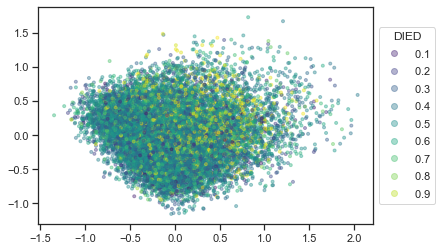

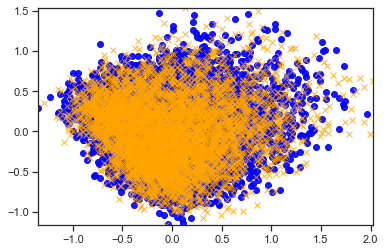

In [8]:
nb_to_plot = min(train.shape[0], 5000)

pca = train.pca(n_components=2).plot(c=train.get_data('y'))

pca_tr = train.pca(n_components=2)[:nb_to_plot]
pca_te = test.pca(n_components=2)[:nb_to_plot]
apd.plot(pca_tr, pca_te)

In [14]:
train.distance(test)

0

### b. Training

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 13463 samples, validate on 13463 samples
Epoch 1/20
13463/13463 [==============================] - 3s 256us/step - loss: 235.0496 - val_loss: 233.3473
Epoch 2/20
13463/13463 [==============================] - 1s 41us/step - loss: 232.3384 - val_loss: 231.6429
Epoch 3/20
13463/13463 [==============================] - 1s 41us/step - loss: 231.2446 - val_loss: 230.8736
Epoch 4/20
13463/13463 [==============================] - 1s 52us/step - loss: 230.8008 - val_loss: 230.5981
Epoch 5/20
13463/13463 [==============================] - 1s 56us/step - loss: 230.4924 - val_loss: 230.3776
Epoch 6/20
13463/13463 [==============================] - 1s 51us/step - loss: 230.3189 - val_loss: 230.1674
Epoch 7/20
13463/13463 [==============================] - 1s 46us/step - loss: 230.1110 - val_loss: 230.0644
Epoch 8/20
13463/13463 [==============================] - 1s 58us/

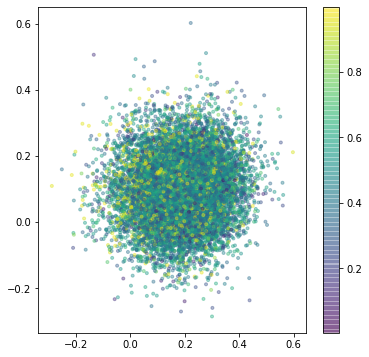

In [5]:
batch_size=128
epochs=20

model = apd.generators.VAE(original_dim, intermediate_dim=[], latent_dim=8)
vae, encoder, decoder = model.get_vae(), model.get_encoder(), model.get_decoder()

columns = train.columns
test_np = test.as_matrix()

model.fit(train,
          shuffle=True,
          epochs=epochs,
          batch_size=batch_size,
          validation_data=(test_np, test_np))

# display a 2D plot of the digit classes in the latent space
z_test = encoder.predict(test_np, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(z_test[:, 0], z_test[:, 1], c=np.array(test.get_data('y').T).ravel(),
            alpha=.4, s=3**2, cmap='viridis')
plt.colorbar()
plt.show()

### c. Benchmark

In [20]:
# Generate samples
n = test.shape[0]
decoded = model.sample(n, loc=0, scale=10)

In [36]:
decoded.distance(test)

0

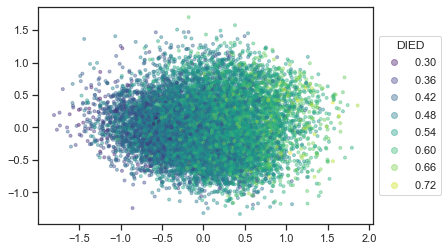

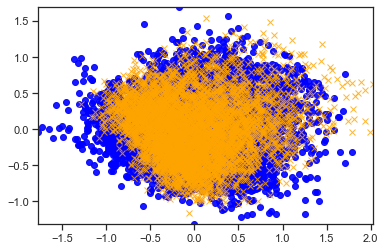

In [21]:
pca = decoded.pca(n_components=2).plot(c=decoded.get_data('y'))

pca_dec = decoded.pca(n_components=2)[:nb_to_plot]
pca_te = test.pca(n_components=2)[:nb_to_plot]
apd.plot(pca_dec, pca_te)

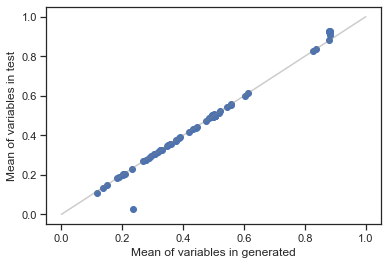

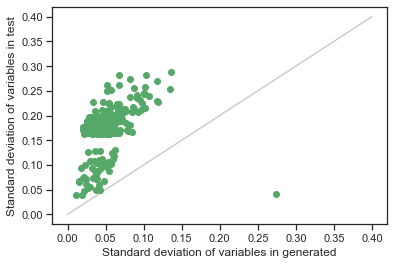

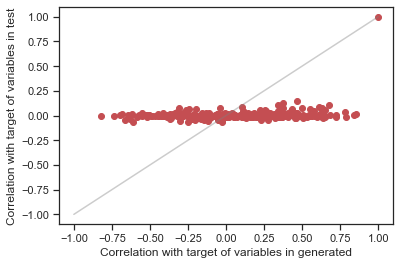

In [22]:
apd.compare_marginals(decoded, test, method='mean', name1='generated', name2='test')
apd.compare_marginals(decoded, test, method='std', name1='generated', name2='test')
apd.compare_marginals(decoded, test, method='corr', target='DIED', name1='generated', name2='test')

In [ ]:
# save generated data
#x_decoded.to_csv('data/mimic_generated_sdv.csv')